# Исследование Рынка заведений общественного питания Москвы

**Причина исследования:**
* Планирование открытия небольшого заведения общественного питания в Москве, в котором обслуживанием поситителей занимаются роботы.

**Цель исследования:**
* Изучение текущего положения на рынке заведений общественного питания Москвы.
* Предоставление рекомендаций по виду заведения, количеству посадочных мест, району расположению и возможности развития сети. 
* Создание презентации для потенциальных инвесторов.

**Оглавление**
1. [Открытие данных](#start)
2. [Предобработка данных](#preprocessing)<br>
    2.1.[Обработка пропущенных значений](#null)<br>
    2.2.[Обработка дубликатов](#duplicates)<br>
3. [Анализ данных](#analysis)<br>
    3.1.[Исследование соотношения видов объектов общественного питания по количеству](#3.1)<br>
    3.2.[Исследование соотношения сетевых и несетевых заведений по количеству](#3.2)<br>
    3.3.[Исследование зависимости вида объекта общественного питания и сетевого распространения](#3.3)<br>
    3.4.[Исследование сетевых заведений: взаимосвязь количества посадочных мест и количества заведений в сети](#3.4)<br>
    3.5.[Исследование среднего количество посадочных мест для каждого вида объекта общественного питания](#3.5)<br>
    3.6.[Создание столбца с информацией об улице из столбца address ](#3.6)<br>
    3.7.[Топ-10 улиц по количеству объектов общественного питания. Привязка улиц к районам](#3.7)<br>
    3.8.[Число улиц с одним объектом общественного питания. Привязка улиц к районам](#3.8)<br>
    3.9.[Исследование распределения количества посадочных мест для улиц с большим количеством объектов общественного питания](#3.9)<br>
4. [Общий вывод. Рекомендации о виде заведения, количестве посадочных мест, а также районе расположения](#conclusion)

## <a id="start">Открытие данных</a> 

In [1]:
# загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# максимально отображаемая длина стороки
pd.set_option("max_colwidth", 110)

In [3]:
# стиль графиков
plt.style.use('ggplot')

In [4]:
# загрузка данных
df = pd.read_csv('/datasets/rest_data.csv')
# таблица с данными об улицах и районах Москвы
mos = pd.read_csv('https://frs.noosphere.ru/xmlui/bitstream/handle/20.500.11925/714058/mosgaz-streets.csv')

In [5]:
df.sample(3)

,id,object_name,chain,object_type,address,number
13601,205360,Гриль Бар,нет,бар,"город Москва, улица Большая Ордынка, дом 7",12
5490,156198,Кафе,нет,кафе,"город Москва, Байкальская улица, дом 1/3, строение 5",40
5567,28487,Атриум,нет,кафе,"город Москва, Русаковская улица, дом 24",55


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


**Выводы:**
* Данные отображаются корректно
* Тип данных в столбац соответствует содержимому
* Стиль в названии столбцов соблюден

## <a id="preprocessing">Предобработка данных</a> 

### <a id="null">Обработка пропущенных значений</a> 

In [7]:
df.isna().sum()
print(f'Количество пропущенных значений:\n{df.isna().sum()}')

Количество пропущенных значений:
id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64


### <a id="duplicates">Обработка дубликатов</a> 

In [8]:
print(f'Количество полных строк-дубликатов: {df.duplicated().sum()}')

Количество полных строк-дубликатов: 0


В таблице содержится большое количество одинаковых заведений, но написанных по-разному, например:

In [9]:
df[df['object_name'].str.contains('Макдоналдс', case=False)]['object_name'].unique()

array(['МАКДОНАЛДС', 'Ресторан «Макдоналдс»', 'Макдоналдс',
       'Предприятие быстрого обслуживания «Макдоналдс»',
       'МОСКВА - МАКДОНАЛДС', 'КАФЕ МАКДОНАЛДС', 'КАФЕ «МАКДОНАЛДС»',
       'Кафе «МАКДОНАЛДС»', 'РЕСТОРАН«МАКДОНАЛДС»', 'Кафе «Макдоналдс»'],
      dtype=object)

Нужно это исправить хотя бы для самых больших сетей.

In [10]:
# в таблице содержится большое количество одинаковых заведений, 
# но написанных по-разному, нужно это исправить хотя бы для самых больших сетей.
# напишем функцию, которая находит определенную поlстроку в ячейке и заменяет всю ячейку на новое значение
def dupl(duplicates, names):
    for i, k in zip(duplicates, names):
        df.loc[df['object_name'].str.contains(i, case=False), 'object_name'] = k
# подстроки для замены
old = ['кфс', 'kfc', 'чайхона №1', 'Шоколадница', 'Додо Пицца', 
       'Бургер Кинг', 'с Пицца', 'McDonald', 'Макдоналдс', 
       'Теремок', 'starb', 'старбакс', 'Папа Джонс', 'Subway', 
       'Кофемания', 'Иль Патио', 'IL Патио', 'Крошка Картошка', 
       'Мята ', 'Милти', 'Суши Wok','Cofix', 'Кофе Хаус', 
       'Хлеб насущный', 'Якитория', 'Тануки', 'Прайм Стар', 
       'Пицца Хат', 'Му-Му', 'СушиШоп', 'Кулинарная лавка братьев Караваевых', 
       'Пицца Паоло', 'Баскин Роббинс', 'Андерсон', 'Алло Пицца', 'Волконский', 
       'Штолле', 'Кружка', 'СтардогS']
# новые названия
new = ['KFC', 'KFC', 'Чайхона №1', 'Шоколадница', 'Додо Пицца', 
       'Бургер Кинг', 'Domino’s Pizza', 'Макдоналдс', 'Макдоналдс', 
       'Теремок', 'Starbucks', 'Starbucks', 'Папа Джонс', 'Subway', 
       'Кофемания', 'IL Патио', 'IL Патио', 'Крошка Картошка', 
       'Мята Lounge', 'Милти', 'Суши Wok', 'Cofix', 'Кофе Хаус', 
       'Хлеб насущный', 'Якитория', 'Тануки', 'Прайм Стар', 
       'Пицца Хат', 'Му-Му', 'СушиШоп', 'Кулинарная лавка братьев Караваевых', 
       'Пицца Паоло', 'Baskin Robbins', 'Андерсон', 'Алло Пицца', 'Волконский', 
       'Кружка', 'СтардогS']
dupl(old, new)

In [11]:
# проверим Мак снова
df[df['object_name'].str.contains('Макдоналдс', case=False)]['object_name'].unique()

array(['Макдоналдс'], dtype=object)

## <a id="analysis">Анализ данных</a> 

### <a id="3.1">Исследование соотношения видов объектов общественного питания по количеству </a> 

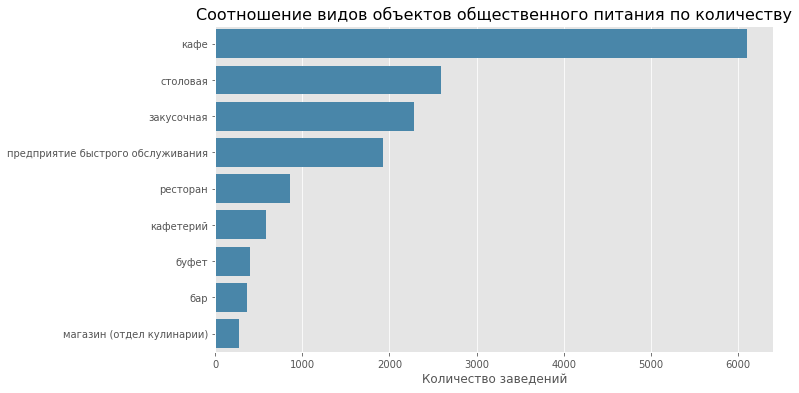

In [12]:
# посчет количества заведений по виду объектов общественного питания
object_count = df['object_type'].value_counts()
# названия видов объектов общественного питания
object_type = df['object_type'].unique()

plt.figure(figsize=(10, 6))
sns.barplot(x=object_count, y=object_type, color='#398AB9')
plt.title('Cоотношение видов объектов общественного питания по количеству', size=16)
plt.xlabel('Количество заведений')
plt.show()

**Выводы:**
* *Кафе* - самый распространенный вид объектов общественного питания. Возможно данный вид заведения часто окрывают из-за популярности среди потребителей (относительно недорого, есть обслуживающий персонал, возможность проведения мероприятий, комфортная обстановка)

* *Магазин (отдел кулинарии)* - наименее популярный вид объектов общественного питания.

### <a id="3.2">Исследование соотношения сетевых и несетевых заведений по количеству</a> 

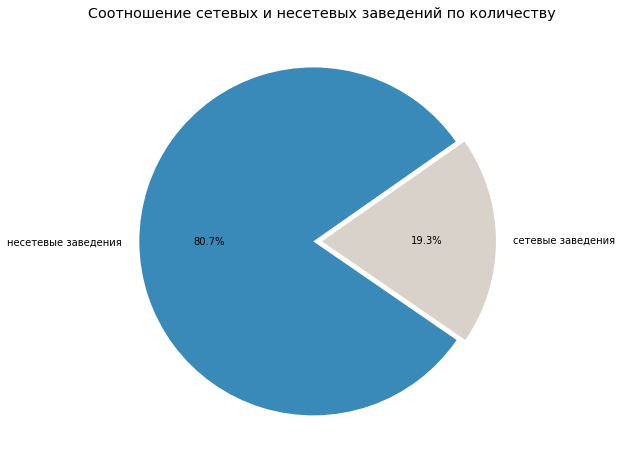

In [13]:
plt.figure(figsize=(8, 8))

plt.pie(
    df['chain'].value_counts(normalize=True), # cоотношение сетевых и несетевых заведений в процентах
    labels=['несетевые заведения', 'сетевые заведения'],
    colors=['#398AB9', '#D8D2CB'], 
    autopct='%1.1f%%', 
    startangle=35, 
    explode = [0.05,0]
)
plt.title('Соотношение сетевых и несетевых заведений по количеству')
plt.show()

**Выводы:**
* Большинство заведений не являются сетевыми. Вероятно создание сети заведений подразумевает бóльшие финансовые затраты.

### <a id="3.3">Исследование зависимости вида объекта общественного питания и сетевого распространения</a> 

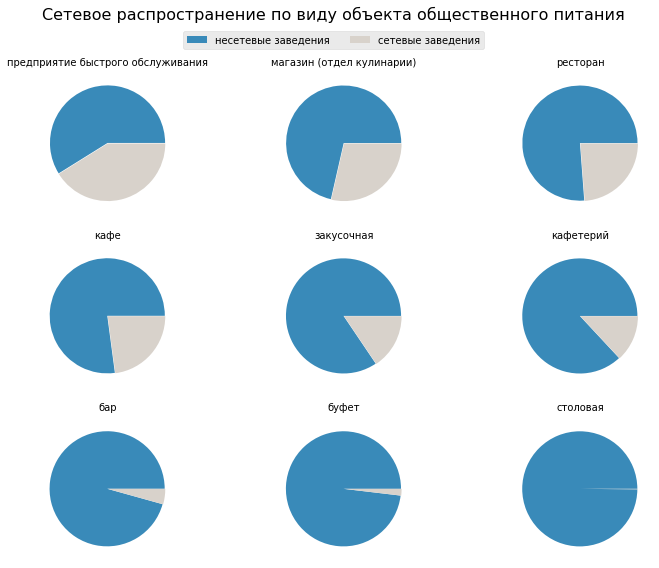

In [14]:
# подсчет сетевых и несетевых заведений в зависимости от вида объекта общественного питания
object_chain = df.groupby(['object_type', 'chain'])['id'].count().unstack().reset_index()\
# доля сетевых заведений в процентах
object_chain['perc'] = object_chain['да'] / object_chain['нет']*100
# сортировка таблицы по долям
object_chain = object_chain.sort_values('perc', ascending=False)
# названия видов объектов общественного питания
lst = object_chain['object_type'].unique()

fig = plt.figure(figsize=(12,9))
plt.suptitle('Сетевое распространение по виду объекта общественного питания', fontsize=16)

# для каждого вида объектов общественного питания построим круговую диаграмму 
for i, k in enumerate(lst):
    ax=fig.add_subplot(3, 3, i+1)
    object_type = df[df['object_type'] == k]
    ax.pie(
        object_type['chain'].value_counts(),
        colors=['#398AB9', '#D8D2CB'], 
        explode = [0.01,0]
    )
    ax.set_title(k, fontsize=10)
fig.legend(['несетевые заведения', 'сетевые заведения'], 
           ncol=2, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 0.95))
plt.show()

**Вывод:**
* Сетевое распространение **наиболее** характерно для *предприятий быстрого обслуживания и магазинов(отдел кулинарии)*. Можно преположить, что относительно других видов заведений, их легче масштабировать из-за  меньшей суммы финансовых вложений.
* Сетевое распространение **наименее** характерно для *буфетов и столовых*. Данные заведения в основном распологаются на территории различных предприятий, компаний, учебных заведений и финансируются за счет данных структур.

### <a id="3.4">Исследование сетевых заведений: взаимосвязь количества посадочных мест и количества заведений в сети</a> 

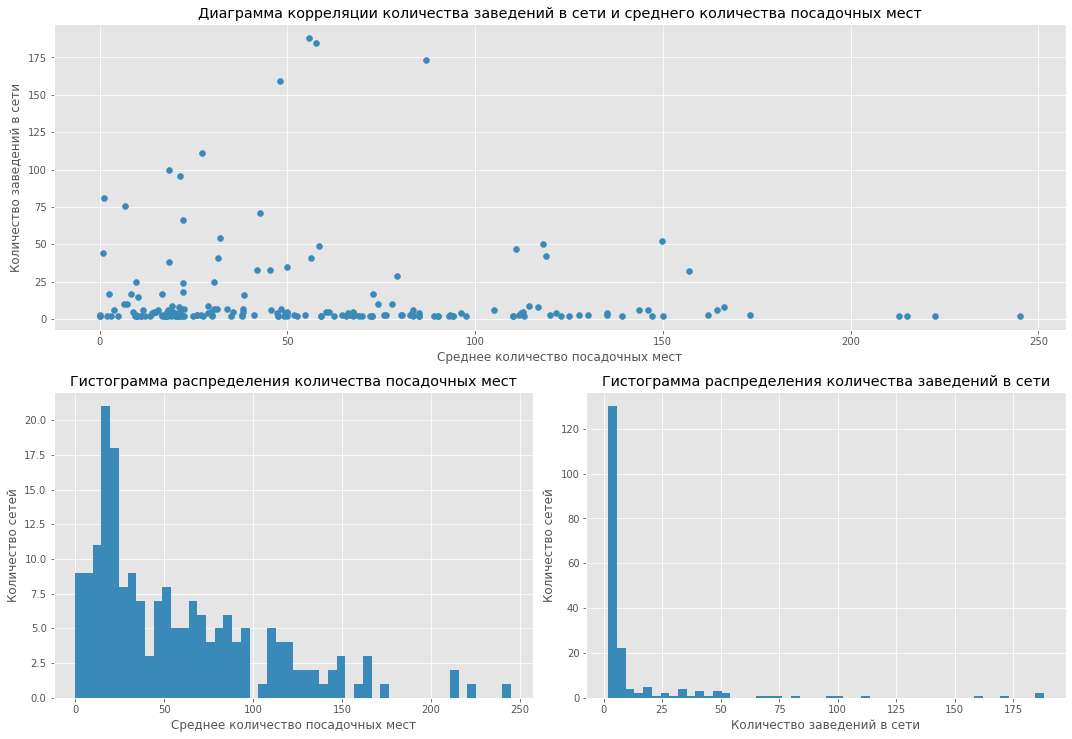

In [15]:
quantity_number = (df.query('chain == "да"')
                   .groupby('object_name')
                   .agg({'id':'count', 'number':'mean'})
                   .sort_values('id', ascending=False))

# убирем сети с одним заведением, т.к. не все неявные дубликаты были заменены и они будут создавать лишний шум
quantity_number = quantity_number[quantity_number['id'] >1]

fig = plt.figure(figsize=(15, 15))

ax_1 = fig.add_subplot(3, 1, 1)
ax_2 = fig.add_subplot(3, 2, 3)
ax_3 = fig.add_subplot(3, 2, 4)

ax_1.scatter(x=quantity_number['number'], y=quantity_number['id'], color='#398AB9')
ax_1.set_xlabel('Среднее количество посадочных мест')
ax_1.set_ylabel('Количество заведений в сети')
ax_1.set_title('Диаграмма корреляции количества заведений в сети и среднего количества посадочных мест')

ax_2.hist(quantity_number['number'], bins=50, color='#398AB9')
ax_2.set_xlabel('Среднее количество посадочных мест')
ax_2.set_ylabel('Количество сетей')
ax_2.set_title('Гистограмма распределения количества посадочных мест')

ax_3.hist(quantity_number['id'], bins=50, color='#398AB9')
ax_3.set_xlabel('Количество заведений в сети')
ax_3.set_ylabel('Количество сетей')
ax_3.set_title('Гистограмма распределения количества заведений в сети')
plt.tight_layout()
plt.show()

In [16]:
quantity_number.describe(percentiles=[.05, .95])

,id,number
count,192.000000,192.000000
mean,13.932292,57.728831
std,30.158926,49.209177
min,2.000000,0.000000
5%,2.000000,5.825000
50%,3.000000,45.515152
95%,68.250000,149.820192
max,188.000000,245.000000


**Вывод:**
* Половина сетей включает не более 3-х заведений. Количество заведений варьируется от 2 до 68.
* В половине сетей  не более 46 посадочных мест. В большинстве сетей количество посадочных мест варьируется от 6 до 150.

В итоге для сетевых заведений более характерно наличие небольшого количества точек и среднее количество посадочных мест.

### <a id="3.5">Исследование среднего количество посадочных мест для каждого вида объекта общественного питания</a> 

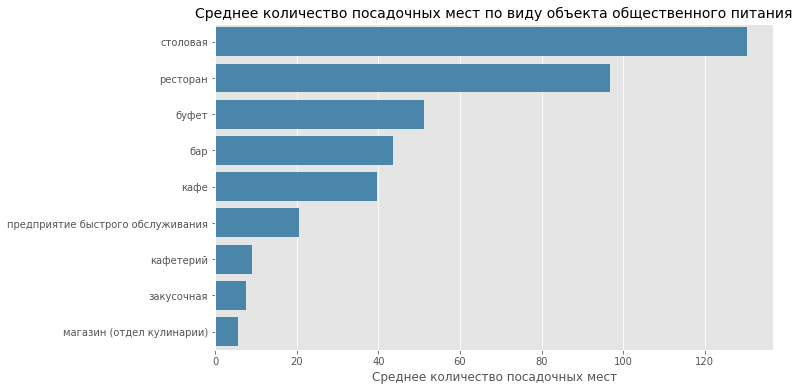

In [17]:
# найдем среднее количество посадочных мест для каждого вида объекта общественного питания
type_number = (df.groupby('object_type', as_index=False)[['number']]
               .mean()
               .sort_values('number', ascending=False))

plt.figure(figsize=(10, 6))
sns.barplot(x='number', y='object_type', data=type_number, color='#398AB9')
plt.title('Cреднее количество посадочных мест по виду объекта общественного питания', size=14)
plt.xlabel('Cреднее количество посадочных мест')
plt.ylabel('')
plt.show()

**Вывод:**
* Больше всего посадочных мест в столовых и ресторанах. Столовые как уже было сказано располагаются при предприятиях и учебных заведениях, то есть в местах с большим количеством людей. 
* Кафе расположились в середине списка. Можно преположить, что популярность кафе среди препринимателей также обусловлена небольшим количеством посадочных мест, а значит и небольшим помещением, что снижает расходы. 
* За кафе расположилось предприятие быстрого обслуживания. Оно похоже на кафе по функционалу, но с вдвое меньшим количеством посадочных мест, что говорит о еще меньшей стоимостью аренды помещения.
* Меньше всего посадочных мест в закусочных и магазинах (отдел кулинарии)

### <a id="3.6">Создание столбца с информацией об улице из столбца address</a> 

In [18]:
# список типов московских улиц
words = ['улица', 'переулок', 'шоссе', 'проспект', 'площадь', 'проезд', 'посёлок', 'проектируемый проезд', 'просек',
         'аллея', 'бульвар', 'набережная', 'тупик', 'линия', 'деревня', 'квартал', 'микрорайон', 'мост', 'парк', 'село']
# регулярное выражение для поиска улиц
str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))
# создание столбца с улицами
df["street"] = df["address"].str.extract(str_pat, flags=re.I)
df.head()

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


### <a id="3.7">Топ-10 улиц по количеству объектов общественного питания. Привязка улиц к районам</a> 

In [19]:
# найдем топ-10 улиц по количеству объектов общественного питания
top_10 = (
    df.groupby('street', as_index=False)[['id']]
    .count()
    .sort_values('id', ascending=False)
    .head(10)
)

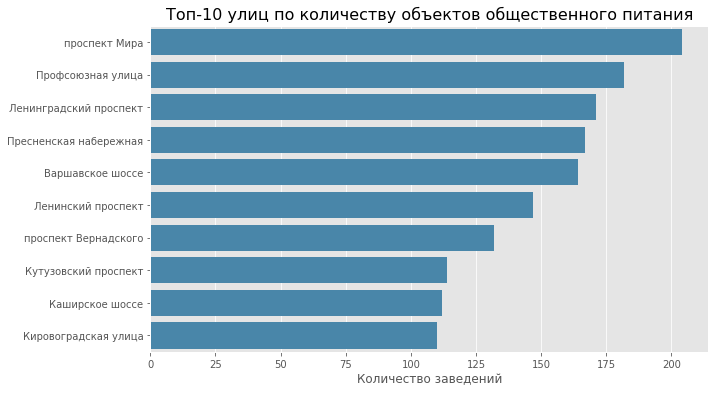

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x='id', y='street', data=top_10, color='#398AB9')
plt.title('Топ-10 улиц по количеству объектов общественного питания', size=16)
plt.xlabel('Количество заведений')
plt.ylabel('')
plt.show()

In [21]:
top_10 = top_10.merge(mos['area'], how='left', left_on='street', right_on=mos['streetname'])

In [22]:
print(f'Районы, в которых больше всего улиц из топ-10 по количеству объектов общественного питания\n\n{top_10.groupby("area")[["street"]].count().sort_values("street", ascending=False).head(11)}')

Районы, в которых больше всего улиц из топ-10 по количеству объектов общественного питания

                             street
area                               
Район Чертаново Центральное       2
Донской район                     2
Ломоносовский район               2
Район Проспект Вернадского        2
Обручевский район                 2
Район Теплый Стан                 2
Район Нагатино-Садовники          2
Район Чертаново Южное             2
Район Тропарево-Никулино          2
Район Гагаринский                 2
Район Чертаново Северное          2


### <a id="3.8">Число улиц с одним объектом общественного питания. Привязка улиц к районам</a> 

In [23]:
# подсчет количества объектов общественного питания на каждой улице
only_one = df.groupby('street', as_index=False)['id'].count()
# делаем срез - только одно заведение на улице
only_one = only_one[only_one['id'] == 1].reset_index(drop=True)
# привязка улиц к районам
only_one = only_one.merge(mos['area'], how='left', left_on='street', right_on=mos['streetname'])
only_one.head()

,street,id,area
0,1-й Балтийский переулок,1,Район Аэропорт
1,1-й Басманный переулок,1,Басманный район
2,1-й Басманный переулок,1,Красносельский район
3,1-й Ботанический проезд,1,Район Свиблово
4,1-й Вешняковский проезд,1,Рязанский район


In [24]:
# подсчет количества улиц в каждом районе
only_one_area = only_one.groupby('area')[['street']].count().sort_values('street', ascending=False).head(10)

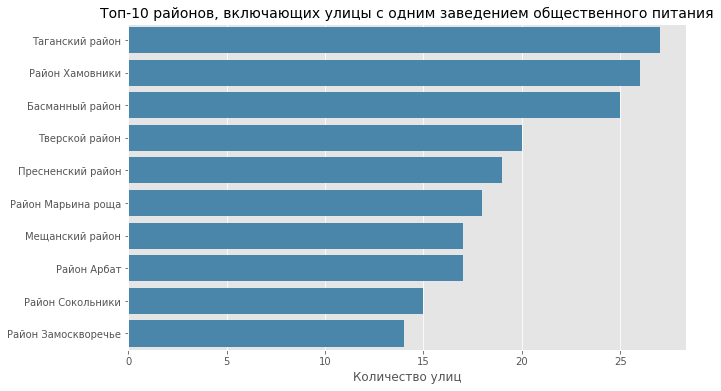

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x='street', y=only_one_area.index, data=only_one_area, color='#398AB9')
plt.title('Топ-10 районов, включающих улицы с одним заведением общественного питания', size=14)
plt.xlabel('Количество улиц')
plt.ylabel('')
plt.show()

In [26]:
only_one_area

,street
area,
Таганский район,27
Район Хамовники,26
Басманный район,25
Тверской район,20
Пресненский район,19
Район Марьина роща,18
Мещанский район,17
Район Арбат,17
Район Сокольники,15


### <a id="3.9">Исследование распределения количества посадочных мест для улиц с большим количеством объектов общественного питания</a> 

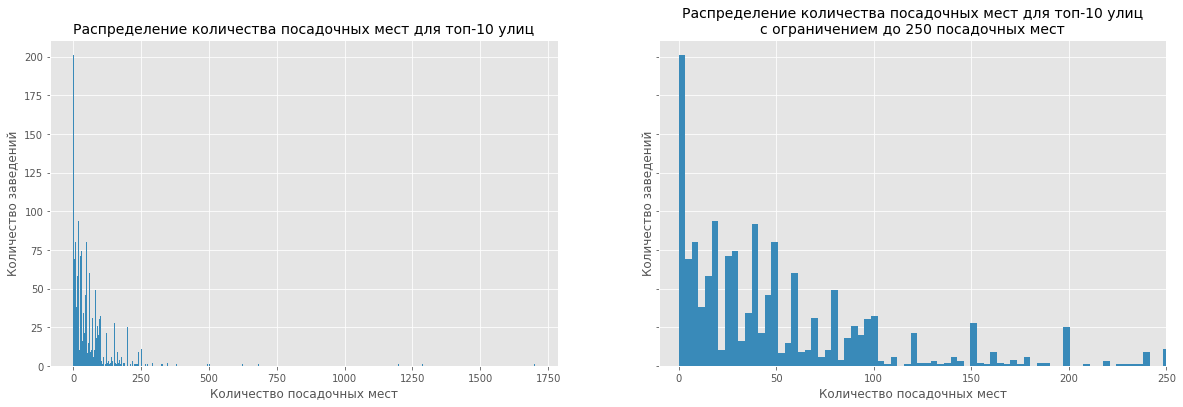

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (20, 6))

# построим гистограммы распределения количества посадочных мест для топ-10 улиц по количеству объектов общественного питания  
ax1.hist(df.query('street in @top_10["street"].unique()')['number'], bins=500, color='#398AB9')
ax1.set_title('Распределение количества посадочных мест для топ-10 улиц', fontsize=14)
ax1.set_xlabel('Количество посадочных мест')
ax1.set_ylabel('Количество заведений')

# гистограмма с лимитом 250 по оси x
ax2.hist(df.query('street in @top_10["street"].unique()')['number'], bins=500, color='#398AB9')
ax2.set_title('Распределение количества посадочных мест для топ-10 улиц\nс ограничением до 250 посадочных мест',  fontsize=14)
ax2.set_xlabel('Количество посадочных мест')
ax2.set_ylabel('Количество заведений')
ax2.set_xlim(-10,250)

plt.show()

In [28]:
df.query('street in @top_10["street"].unique()')['number'].describe(percentiles=[0.05, 0.95])

count    1503.000000
mean       57.966733
std        89.982933
min         0.000000
5%          0.000000
50%        40.000000
95%       200.000000
max      1700.000000
Name: number, dtype: float64

**Вывод:**
* В половине заведений количество посадочных мест не превышает 40. 
* Большинство заведений имеют от 0 до 200 посадочных мест.

## <a id="conclusion">Общий вывод. Рекомендации о виде заведения, количестве посадочных мест, а также районе расположения</a> 

**Основные факторы, влияющие на проект:**
* Небольшое кафе в Москве
* гостей обслуживают роботы
* Проект дорогой

**В связи с этими данными, а также полученными результатами исследования можно выделить следующие рекомендации:**

* Возможные варианты заведений, количество посадочных мест (среднее количество для каждого вида объектов обещственного питания) и количество подобных объектов в Москве:
    * бар - 45 посадочных мест; малое количество подобных заведений
    * кафе - 40 посадочных мест; очень большое количество подобных заведений
    * предприятие быстрого обслуживания - 20 посадочных мест; среднее количество подобных заведений
    
В связи с тем, что проект дорогой, более предпочтительным в качестве вида заведения можно считать *предприятие быстрого обслуживания* - меньшее количество посадочных мест удешевляет аренду и прочие расходы. Также такой вид заведения легче масштабировать.

Возможные районы расположения заведения:

Районы, в которых больше всего улиц из топ-10 по количеству объектов общественного питания:
* Район Чертаново Центральное
* Донской район
* Ломоносовский район
* Район Проспект Вернадского
* Обручевский район
* Район Теплый Стан
* Район Нагатино-Садовники
* Район Чертаново Южное
* Район Тропарево-Никулино
* Район Гагаринский
* Район Чертаново Северное

Это самые привлекательные и популярные районы, и поэтому здесь самая большая конкуренция.

Районы, в которых наибольшее количество улиц с одним объектом общественного питания:
* Таганский район
* Район Хамовники
* Басманный район
* Тверской район
* Пресненский район
* Район Марьина роща
* Мещанский район
* Район Арбат
* Район Сокольники
* Район Замоскворечье

Эти районы не пользуются популярностью у конкурентов. Скорее всего на это есть обоснованные причины и эти районы лучше не рассматривать.